# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [ ]:
!nvidia-smi

# Download and import required packages

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

In [ ]:
!pip install seaborn

In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt
import seaborn as sns

No protocol specified


# Fix random seed

In [2]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [3]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & valid
    'test.tgz',    # test
)
prefix = Path(data_dir).absolute() / dataset_name

In [4]:
prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


## Language

In [5]:
src_lang = 'zh'
tgt_lang = 'en'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [6]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.


## Preprocess files

In [7]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':                                 # Clean some symbols for English
        s = re.sub(r"\([^()]*\)", "", s)             # remove ([text])
        s = s.replace('-', '')                       # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s)      # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s)                                # Q2B
        s = re.sub(r"\([^()]*\)", "", s)             # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    """
    Arguments:
        prefix: Your raw data path.
        l1    : Source language.
        l2    : Target language.
    """
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()                 # Source sentence.
                        s2 = l2_in_f.readline().strip() # Target sentence.
                        s1 = clean_s(s1, l1)            # Clean source sentence
                        s2 = clean_s(s2, l2)            # Clean target sentence
                        s1_len = len_s(s1, l1)          # Length of source sentence after clean.
                        s2_len = len_s(s2, l2)          # Length of target sentence after clean.
                        if min_len > 0:                 # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0:                 # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0:                   # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [8]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/tienyi/ML/HW05/DATA/rawdata/ted2020/train_dev.raw.clean.zh & en exists. skipping clean.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/test.raw.clean.zh & en exists. skipping clean.


In [9]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


## Split into train/valid

In [10]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [11]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [12]:
import sentencepiece as spm
vocab_size = 16000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='bpe', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/tienyi/ML/HW05/DATA/rawdata/ted2020/spm16000.model exists. skipping spm_train.


In [13]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/tienyi/ML/HW05/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.


In [14]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁非常謝謝 你 ▁, ▁克里斯 ▁。 ▁能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁真 是一 大 榮 幸 ▁。 ▁我非常 感 激 ▁。
▁這個 研 討 會 給我 留下 了 極為 深刻 的 印象 ▁, ▁我想 感謝 大家 對我 之前 演講 的好 評 ▁。
▁我是 由 衷 的 想 這麼說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁請 你們 設 身處 地 為 我想 一 想 ▁!
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁truly ▁a ▁great ▁honor ▁to ▁have ▁the ▁opportunity ▁to ▁come ▁to ▁this ▁stage ▁twice ▁; ▁i ' m ▁extremely ▁gr ate ful ▁.
▁i ▁have ▁been ▁bl own ▁away ▁by ▁this ▁conference ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁nice ▁com ments ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your selves ▁in ▁my ▁position ▁.


## Binarize the data with fairseq

In [15]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [16]:
mono_dataset_name = 'mono'

In [17]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [18]:
src_lang = 'zh'
tgt_lang = 'en'

data_prefix = f'{mono_prefix}/ted_zh_corpus.deduped'

In [19]:
def clean_mono_corpus(prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}', 'r') as l1_in_f:
        with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
            with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0:            # Remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0:            # Remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)  # Fake file

In [20]:
!head {data_prefix} -n 5

在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性


In [21]:
clean_mono_corpus(data_prefix, src_lang, tgt_lang)

/home/tienyi/ML/HW05/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


In [22]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性
.
.
.
.
.


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [23]:
for lang in [src_lang, tgt_lang]:
    out_path = mono_prefix/f"mono.tok.{lang}"
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(out_path, 'w') as out_f:
            with open(f'{data_prefix}.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

/home/tienyi/ML/HW05/DATA/rawdata/mono/mono.tok.zh exists. skipping spm_encode.
/home/tienyi/ML/HW05/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.


In [24]:
!head {str(mono_prefix)+'/mono.tok.'+src_lang} -n 5
!head {str(mono_prefix)+'/mono.tok.'+tgt_lang} -n 5

▁在 16 世紀 中 葉 意 大利 人 被 一種 男 歌 手 迷 住了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包含 的 音 高 先前 是一 般 成年 男性 不可能 達 到的
▁但是 ▁, ▁這 天 賦 有一個 很 高的 代價
▁要 防止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停止 荷 爾蒙 的 變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的聲音 在 整個 歐洲 很有 名 直到 這個 殘 酷 的 程序 ▁, ▁在 19 世紀 被 禁止
▁雖然 阻止 聲 帶 的 成長 ▁, ▁可以 產生 一個 非凡 廣 闊 的 音 域 但 自然 發展 的聲音 ▁, ▁已經 具有 極 多的 可能性
▁in ▁the ▁mid 16 th ▁century ▁, ▁it al ians ▁were ▁m es mer ized ▁by ▁a ▁kind ▁of ▁male ▁sing er ▁whose ▁scale ▁cont ained ▁notes ▁previous ly ▁impossible ▁for ▁adult ▁men ▁.
▁but ▁there ' s ▁a ▁high ▁price ▁to ▁this ▁gift ▁.
▁to ▁prevent ▁them ▁from ▁breaking ▁, ▁these ▁sing ers ▁had ▁been ▁cast rated ▁before ▁pu ber ty ▁to ▁stop ▁horm on al ▁changes ▁, ▁in ▁order ▁to ▁keep ▁their ▁voices ▁low ▁.
▁it ▁was ▁called ▁cast r at i ▁, ▁and ▁they ▁were ▁re n own ed ▁for ▁their ▁light ▁, ▁ange lic ▁voices ▁throughout ▁europe ▁until ▁this ▁cru el ▁proced ure ▁that ▁was ▁out l aw ed ▁in ▁the ▁19 th ▁century ▁.
▁while ▁stop ping ▁the ▁voc al ▁growth 

### Binarize

use fairseq to binarize data

In [25]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [26]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

# Configuration for experiments

In [27]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/transformer-back-translation",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=8,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=8,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=50,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=15,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [28]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [29]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2022-03-28 20:08:57 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-03-28 20:08:57 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.692 GB ; name = NVIDIA GeForce RTX 3090                 
2022-03-28 20:08:57 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [30]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-03-28 20:08:59 | INFO | fairseq.tasks.translation | [zh] dictionary: 15960 types
2022-03-28 20:08:59 | INFO | fairseq.tasks.translation | [en] dictionary: 15960 types


In [31]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-03-28 20:08:59 | INFO | hw5.seq2seq | loading data for epoch 1
2022-03-28 20:08:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.zh
2022-03-28 20:08:59 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.zh-en.en
2022-03-28 20:08:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2022-03-28 20:08:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.zh
2022-03-28 20:08:59 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.zh-en.en
2022-03-28 20:08:59 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [32]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  105,  3468,   212,  3655,   930,   356,   440,   408, 10591,  4059,
            2]),
 'target': tensor([  13,   10,   18, 1543,   39,   16,   56, 9225,  653, 1160, 1339,    5,
           2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [33]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-03-28 20:09:02 | WARNING | fairseq.tasks.fairseq_task | 2,030 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[668, 1772, 2675, 669, 2032, 447, 636, 137, 2816, 2731]


{'id': tensor([1702]),
 'nsentences': 1,
 'ntokens': 12,
 'net_input': {'src_tokens': tensor([[7240, 8806,    4, 1776,   34,  290,    4,    2]]),
  'src_lengths': tensor([8]),
  'prev_output_tokens': tensor([[   2,   78, 5947,    4,   28,   10,   54,  691,   17,   91, 2673,    5,
              1,    1,    1,    1]])},
 'target': tensor([[  78, 5947,    4,   28,   10,   54,  691,   17,   91, 2673,    5,    2,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [34]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [35]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers * batch * num_directions, hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # (seq_len x batch x hidden)
                final_hiddens,  # (num_layers x batch x num_directions*hidden)
                encoder_padding_mask,  # (seq_len x batch)
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [36]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [37]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [38]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [39]:
# HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [40]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=8,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=False
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=False
    
    args.encoder_learned_pos = True
    args.decoder_learned_pos = True
    
    args.encoder_layerdrop = 0.1
    args.decoder_layerdrop = 0.1
    
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [41]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [42]:
model = build_model(arch_args, task)
logger.info(model)

2022-03-28 20:09:34 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(15960, 512, padding_idx=1)
    (embed_positions): LearnedPositionalEmbedding(1026, 512, padding_idx=1)
    (layers): LayerDropModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_featu

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [43]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [44]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    # lr = 0.001
    lr = d_model ** (-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5))
    return lr

In [45]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

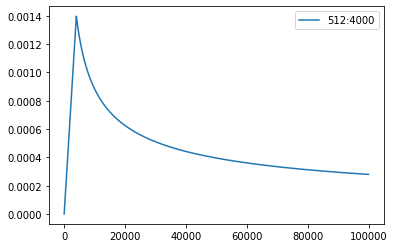

In [46]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [47]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": [], "norm": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        stats["norm"].append(gnorm)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [48]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [49]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [50]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [51]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [52]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-03-28 20:09:48 | INFO | hw5.seq2seq | task: TranslationTask
2022-03-28 20:09:48 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-03-28 20:09:48 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-03-28 20:09:48 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-03-28 20:09:48 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-03-28 20:09:48 | INFO | hw5.seq2seq | num. model params: 76,244,992 (num. trained: 76,244,992)
2022-03-28 20:09:48 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 8


In [55]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
norm = []
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    stats = train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    norm += stats["norm"]
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-03-28 00:16:02 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-back-translation/checkpoint_last.pt: step=14834 loss=3.0141279697418213 bleu=21.434513106586312


# Submission

In [53]:
# averaging a few checkpoints can have a similar effect to ensemble
checkpoint_name = f"avg_last_{config.keep_last_epochs}_checkpoint.pt"
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints {config.keep_last_epochs} \
--output {checkdir}/{checkpoint_name}

No protocol specified
Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-back-translation'], num_epoch_checkpoints=15, num_update_checkpoints=None, output='./checkpoints/transformer-back-translation/avg_last_15_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-back-translation/checkpoint50.pt', './checkpoints/transformer-back-translation/checkpoint49.pt', './checkpoints/transformer-back-translation/checkpoint48.pt', './checkpoints/transformer-back-translation/checkpoint47.pt', './checkpoints/transformer-back-translation/checkpoint46.pt', './checkpoints/transformer-back-translation/checkpoint45.pt', './checkpoints/transformer-back-translation/checkpoint44.pt', './checkpoints/transformer-back-translation/checkpoint43.pt', './checkpoints/transformer-back-translation/checkpoint42.pt', './checkpoints/transformer-back-translation/checkpoint41.pt', './checkpoints/transformer-back-translation/checkpoint40.pt', './checkpoints/transformer-back-translation

## Confirm model weights used to generate submission

In [54]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name=checkpoint_name)
validate(model, task, criterion, log_to_wandb=False)
None

2022-03-28 20:09:56 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-back-translation/avg_last_15_checkpoint.pt: step=unknown loss=3.0141279697418213 bleu=21.434513106586312
2022-03-28 20:09:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/38 [00:00<?, ?it/s, valid_loss=2.49]/home/tienyi/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/tienyi/.local/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

2022-03-28 20:10:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-03-28 20:10:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-03-28 20:10:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-03-28 20:10:18 | INFO | hw5.seq2seq | example source: " 我可以拿出來大講特講 "
2022-03-28 20:10:18 | INFO | hw5.seq2seq | example hypothesis: i can get out of the way and give a talk . "
2022-03-28 20:10:18 | INFO | hw5.seq2seq | example reference: i can sink my teeth into this . "
2022-03-28 20:10:18 | INFO | hw5.seq2seq | validation loss:	2.9202
2022-03-28 20:10:18 | INFO | hw5.seq2seq | BLEU = 22.65 57.9/30.0/17.7/10.8 (BP = 0.945 ratio = 0.946 hyp_len = 72914 ref_len = 77050)


## Generate Prediction

In [55]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [56]:
generate_prediction(model, task, split='mono', outfile="./DATA/rawdata/mono/mono_prediction.txt")

2022-03-28 20:10:18 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2022-03-28 20:10:18 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2022-03-28 20:10:18 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction: 100%|██████████| 2854/2854 [35:12<00:00,  1.35it/s]


In [57]:
!head {"./DATA/rawdata/mono/mono_prediction.txt"} -n 5

in the mid16th century , italians were mesmerized by a kind of male singer whose scale contained notes previously impossible for adult men .
but there's a high price to this gift .
to prevent them from breaking , these singers had been castrated before puberty to stop hormonal changes , in order to keep their voices low .
it was called castrati , and they were renowned for their light , angelic voices throughout europe until this cruel procedure that was outlawed in the 19th century .
while stopping the vocal growth can produce an extraordinary range of voices , naturally developing voices are already capable of incredible possibilities .


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [58]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
# Mono prediction txt file to mono.tok.en
with open(f"{str(mono_prefix)}/mono.tok.en", 'w') as out_f:
    with open(f"{str(mono_prefix)}/mono_prediction.txt", 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/synthetic exists, will not overwrite!


In [59]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

In [60]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
with open(f"{str(mono_prefix)}/mono.tok.en", 'w') as out_f:
    with open(f"{str(mono_prefix)}/mono_prediction.txt", 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/synthetic exists, will not overwrite!


Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

# Retrain a model to translate English to Traditional Chinese

# Configuration for experiments

In [61]:
# Configuration
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer-big",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=8,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=8,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=4.,
    lr_warmup=6000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=50,
    start_epoch=1,
    
    # beam size for beam search
    beam=10, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=15,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [62]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [63]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2022-03-28 20:52:34 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-03-28 20:52:34 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.692 GB ; name = NVIDIA GeForce RTX 3090                 
2022-03-28 20:52:34 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [64]:
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-03-28 20:52:34 | INFO | fairseq.tasks.translation | [en] dictionary: 15960 types
2022-03-28 20:52:34 | INFO | fairseq.tasks.translation | [zh] dictionary: 15960 types


In [65]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-03-28 20:52:34 | INFO | hw5.seq2seq | loading data for epoch 1
2022-03-28 20:52:34 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.en
2022-03-28 20:52:34 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.zh
2022-03-28 20:52:34 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-03-28 20:52:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-03-28 20:52:34 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-03-28 20:52:34 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2022-03-28 20:52:34 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.zh-en.en
2022-03-28 20:52:34 | I

In [66]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  13,   10,   18, 1543,   39,   16,   56, 9225,  653, 1160, 1339,    5,
           2]),
 'target': tensor([  105,  3468,   212,  3655,   930,   356,   440,   408, 10591,  4059,
            2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


# Dataset iterator

In [67]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-03-28 20:52:34 | WARNING | fairseq.tasks.fairseq_task | 2,030 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 1025, 682, 935, 648, 672, 2524, 222, 1484, 984]


{'id': tensor([1236]),
 'nsentences': 1,
 'ntokens': 7,
 'net_input': {'src_tokens': tensor([[  1,   1,   1,   1,   1,  32, 273,  56,  16,  35,   9, 165,   9, 641,
            25,   2]]),
  'src_lengths': tensor([11]),
  'prev_output_tokens': tensor([[   2, 7167,  994, 2058,  146, 7724,   25,    1]])},
 'target': tensor([[7167,  994, 2058,  146, 7724,   25,    2,    1]])}

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [68]:
# Model Configuration
arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=4096,
    encoder_layers=8,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=4096,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    # args.encoder_learned_pos = True
    # args.decoder_learned_pos = True
    
    args.encoder_layerdrop = 0.1
    args.decoder_layerdrop = 0.1
    
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [69]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [70]:
model = build_model(arch_args, task)
logger.info(model)

2022-03-28 20:52:38 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(15960, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): LayerDropModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, 

# Criterion (Loss Function)

In [71]:
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

# Optimizer with Scheduling Visualized

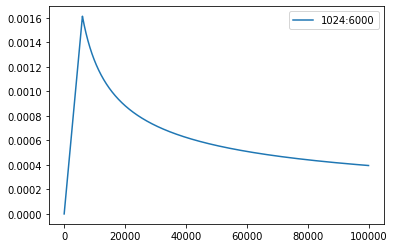

In [72]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])

In [73]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

# Main
## Training loop

In [74]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [75]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-03-28 20:52:38 | INFO | hw5.seq2seq | task: TranslationTask
2022-03-28 20:52:38 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-03-28 20:52:38 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-03-28 20:52:38 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-03-28 20:52:38 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-03-28 20:52:38 | INFO | hw5.seq2seq | num. model params: 267,833,344 (num. trained: 267,833,344)
2022-03-28 20:52:38 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 8


In [76]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
norm = []
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    stats = train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    norm += stats["norm"]
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)


2022-03-28 20:52:38 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer-big/checkpoint_last.pt!


2022-03-28 21:11:39 | INFO | hw5.seq2seq | training loss: 7.1988
2022-03-28 21:11:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/33 [00:00<?, ?it/s, valid_loss=4.56]/home/tienyi/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/tienyi/.local/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mo

2022-03-28 21:12:19 | INFO | hw5.seq2seq | example source: sometimes you will trip .
2022-03-28 21:12:19 | INFO | hw5.seq2seq | example hypothesis: 有時 , 你就會開始 。
2022-03-28 21:12:19 | INFO | hw5.seq2seq | example reference: 有些時候你會被絆倒 。
2022-03-28 21:12:19 | INFO | hw5.seq2seq | validation loss:	5.9100
2022-03-28 21:12:19 | INFO | hw5.seq2seq | BLEU = 6.20 35.1/13.0/5.1/2.2 (BP = 0.738 ratio = 0.767 hyp_len = 85723 ref_len = 111811)
2022-03-28 21:12:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint1.pt
2022-03-28 21:12:22 | INFO | hw5.seq2seq | end of epoch 1


2022-03-28 21:31:24 | INFO | hw5.seq2seq | training loss: 4.9731
2022-03-28 21:31:24 | INFO | hw5.seq2seq | begin validation


2022-03-28 21:32:03 | INFO | hw5.seq2seq | example source: you should have started with z .
2022-03-28 21:32:03 | INFO | hw5.seq2seq | example hypothesis: 你應該從z開始
2022-03-28 21:32:03 | INFO | hw5.seq2seq | example reference: 要從z開始讀 。
2022-03-28 21:32:03 | INFO | hw5.seq2seq | validation loss:	4.4567
2022-03-28 21:32:03 | INFO | hw5.seq2seq | BLEU = 19.37 54.4/28.4/15.4/8.9 (BP = 0.903 ratio = 0.908 hyp_len = 101478 ref_len = 111811)
2022-03-28 21:32:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint2.pt
2022-03-28 21:32:10 | INFO | hw5.seq2seq | end of epoch 2


2022-03-28 21:51:11 | INFO | hw5.seq2seq | training loss: 4.0142
2022-03-28 21:51:11 | INFO | hw5.seq2seq | begin validation


2022-03-28 21:51:56 | INFO | hw5.seq2seq | example source: bruno giussani: alice , basically what you're saying , the talk is , unless wealthy nations start cutting 10 percent per year the emissions now , this year , not in 2020 or '25 , we are going to go straight to the fourplusdegree scenario .
2022-03-28 21:51:56 | INFO | hw5.seq2seq | example hypothesis: 布魯諾·吉尼尼:阿里斯 , 基本上你所說的 , 演講是 , 除非富裕國家在每年排放量開始減少百分之十 , 今年 , 不是在20或25年 , 我們將會直接走向四微的情景 。
2022-03-28 21:51:56 | INFO | hw5.seq2seq | example reference: 艾莉絲 , 你演講提到除非富國每年減排10%現在今年開始不是2020或2025年否則我們將直入溫升4°c
2022-03-28 21:51:56 | INFO | hw5.seq2seq | validation loss:	4.0074
2022-03-28 21:51:56 | INFO | hw5.seq2seq | BLEU = 23.11 57.7/31.7/18.3/11.2 (BP = 0.935 ratio = 0.937 hyp_len = 104746 ref_len = 111811)
2022-03-28 21:51:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint3.pt
2022-03-28 21:52:02 | INFO | hw5.seq2seq | end of epoch 3


2022-03-28 22:11:00 | INFO | hw5.seq2seq | training loss: 3.6904
2022-03-28 22:11:00 | INFO | hw5.seq2seq | begin validation


2022-03-28 22:11:38 | INFO | hw5.seq2seq | example source: you've forgotten all about the elephant haven't you ? "
2022-03-28 22:11:38 | INFO | hw5.seq2seq | example hypothesis: 你忘了關於大象沒有你嗎 ? 」
2022-03-28 22:11:38 | INFO | hw5.seq2seq | example reference: 難道你忘了大象嗎 ?
2022-03-28 22:11:38 | INFO | hw5.seq2seq | validation loss:	3.8355
2022-03-28 22:11:38 | INFO | hw5.seq2seq | BLEU = 24.72 59.0/33.5/20.0/12.6 (BP = 0.932 ratio = 0.934 hyp_len = 104403 ref_len = 111811)
2022-03-28 22:11:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint4.pt
2022-03-28 22:11:45 | INFO | hw5.seq2seq | end of epoch 4


2022-03-28 22:30:44 | INFO | hw5.seq2seq | training loss: 3.5219
2022-03-28 22:30:44 | INFO | hw5.seq2seq | begin validation


2022-03-28 22:31:23 | INFO | hw5.seq2seq | example source: in this case , opposites attract .
2022-03-28 22:31:23 | INFO | hw5.seq2seq | example hypothesis: 在這個例子中 , 異性會吸引
2022-03-28 22:31:23 | INFO | hw5.seq2seq | example reference: 在這種情形下 , 異性就會相吸
2022-03-28 22:31:23 | INFO | hw5.seq2seq | validation loss:	3.7362
2022-03-28 22:31:23 | INFO | hw5.seq2seq | BLEU = 25.58 59.1/33.8/20.3/12.8 (BP = 0.953 ratio = 0.954 hyp_len = 106695 ref_len = 111811)
2022-03-28 22:31:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint5.pt
2022-03-28 22:31:29 | INFO | hw5.seq2seq | end of epoch 5


2022-03-28 22:50:28 | INFO | hw5.seq2seq | training loss: 3.4080
2022-03-28 22:50:28 | INFO | hw5.seq2seq | begin validation


2022-03-28 22:51:08 | INFO | hw5.seq2seq | example source: maybe some of them are here now .
2022-03-28 22:51:08 | INFO | hw5.seq2seq | example hypothesis: 或許有些現在就在這裡了 。
2022-03-28 22:51:08 | INFO | hw5.seq2seq | example reference: 現在也許他們其中的一些也坐在這裡 。
2022-03-28 22:51:08 | INFO | hw5.seq2seq | validation loss:	3.6200
2022-03-28 22:51:08 | INFO | hw5.seq2seq | BLEU = 26.60 58.6/33.7/20.4/13.1 (BP = 0.987 ratio = 0.987 hyp_len = 110381 ref_len = 111811)
2022-03-28 22:51:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint6.pt
2022-03-28 22:51:15 | INFO | hw5.seq2seq | end of epoch 6


2022-03-28 23:10:14 | INFO | hw5.seq2seq | training loss: 3.3220
2022-03-28 23:10:14 | INFO | hw5.seq2seq | begin validation


2022-03-28 23:10:54 | INFO | hw5.seq2seq | example source: the mayor defined the city's new normal as one of permanent drought .
2022-03-28 23:10:54 | INFO | hw5.seq2seq | example hypothesis: 市長把城市的新常態定義為永久乾旱之一 。
2022-03-28 23:10:54 | INFO | hw5.seq2seq | example reference: 市長把該市的新常態定義為永久的乾旱 。
2022-03-28 23:10:54 | INFO | hw5.seq2seq | validation loss:	3.5536
2022-03-28 23:10:54 | INFO | hw5.seq2seq | BLEU = 26.92 59.3/34.4/21.0/13.6 (BP = 0.975 ratio = 0.975 hyp_len = 109065 ref_len = 111811)
2022-03-28 23:10:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint7.pt
2022-03-28 23:11:00 | INFO | hw5.seq2seq | end of epoch 7


2022-03-28 23:30:00 | INFO | hw5.seq2seq | training loss: 3.2456
2022-03-28 23:30:00 | INFO | hw5.seq2seq | begin validation


2022-03-28 23:30:39 | INFO | hw5.seq2seq | example source: the idea is very , very simple .
2022-03-28 23:30:39 | INFO | hw5.seq2seq | example hypothesis: 這個想法非常非常簡單 。
2022-03-28 23:30:39 | INFO | hw5.seq2seq | example reference: 這個主意其實很簡單
2022-03-28 23:30:39 | INFO | hw5.seq2seq | validation loss:	3.4987
2022-03-28 23:30:39 | INFO | hw5.seq2seq | BLEU = 27.43 59.7/34.9/21.5/13.9 (BP = 0.976 ratio = 0.977 hyp_len = 109193 ref_len = 111811)
2022-03-28 23:30:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint8.pt
2022-03-28 23:30:46 | INFO | hw5.seq2seq | end of epoch 8


2022-03-28 23:49:44 | INFO | hw5.seq2seq | training loss: 3.1681
2022-03-28 23:49:44 | INFO | hw5.seq2seq | begin validation


2022-03-28 23:50:24 | INFO | hw5.seq2seq | example source: and it's about our fixation with celebrity and celebrity culture , and the importance of the image: celebrity is born of photography .
2022-03-28 23:50:24 | INFO | hw5.seq2seq | example hypothesis: 這是關於我們與名人及名人的文化的修正 , 圖片的重要性:名人是天生的攝影 。
2022-03-28 23:50:24 | INFO | hw5.seq2seq | example reference: 就是我們對名人和名人文化的迷戀以及圖像的重要性 。 名人是從攝影中產生的 。
2022-03-28 23:50:24 | INFO | hw5.seq2seq | validation loss:	3.4376
2022-03-28 23:50:24 | INFO | hw5.seq2seq | BLEU = 27.81 60.3/35.5/22.1/14.5 (BP = 0.966 ratio = 0.967 hyp_len = 108121 ref_len = 111811)
2022-03-28 23:50:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint9.pt
2022-03-28 23:50:31 | INFO | hw5.seq2seq | end of epoch 9


2022-03-29 00:09:30 | INFO | hw5.seq2seq | training loss: 3.0664
2022-03-29 00:09:30 | INFO | hw5.seq2seq | begin validation


2022-03-29 00:10:10 | INFO | hw5.seq2seq | example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2022-03-29 00:10:10 | INFO | hw5.seq2seq | example hypothesis: 看到那張椅子了嗎 ? 橘色的那張 ? 那是有機椅子 。 1940年 。
2022-03-29 00:10:10 | INFO | hw5.seq2seq | example reference: 看見那張椅子嗎 ? 橘黃色那個 ? 這是有機椅子 。 一九四零年 。
2022-03-29 00:10:10 | INFO | hw5.seq2seq | validation loss:	3.3645
2022-03-29 00:10:10 | INFO | hw5.seq2seq | BLEU = 28.38 60.1/35.7/22.3/14.6 (BP = 0.981 ratio = 0.982 hyp_len = 109757 ref_len = 111811)
2022-03-29 00:10:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint10.pt
2022-03-29 00:10:17 | INFO | hw5.seq2seq | end of epoch 10


2022-03-29 00:29:17 | INFO | hw5.seq2seq | training loss: 2.9728
2022-03-29 00:29:17 | INFO | hw5.seq2seq | begin validation


2022-03-29 00:29:57 | INFO | hw5.seq2seq | example source: they did this because this was common practice in medicine , even though it was obvious that this was not a good idea .
2022-03-29 00:29:57 | INFO | hw5.seq2seq | example hypothesis: 他們這麼做是因為在醫學上這是普遍的做法 , 雖然很明顯這並不是個好主意 。
2022-03-29 00:29:57 | INFO | hw5.seq2seq | example reference: 他們這樣做 , 是因為醫學上這是通常的手續 , 即使很明顯的 , 並不是個好主意 。
2022-03-29 00:29:57 | INFO | hw5.seq2seq | validation loss:	3.3270
2022-03-29 00:29:57 | INFO | hw5.seq2seq | BLEU = 28.79 60.9/36.5/23.1/15.3 (BP = 0.967 ratio = 0.967 hyp_len = 108171 ref_len = 111811)
2022-03-29 00:30:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint11.pt
2022-03-29 00:30:04 | INFO | hw5.seq2seq | end of epoch 11


2022-03-29 00:49:06 | INFO | hw5.seq2seq | training loss: 2.8927
2022-03-29 00:49:06 | INFO | hw5.seq2seq | begin validation


2022-03-29 00:49:45 | INFO | hw5.seq2seq | example source: we're supported in our demands by global bodies like unaids , the world health organization and amnesty international .
2022-03-29 00:49:45 | INFO | hw5.seq2seq | example hypothesis: 我們受到聯合國愛滋病組織、世界衛生組織和國際特赦組織的支持 。
2022-03-29 00:49:45 | INFO | hw5.seq2seq | example reference: 支持我們的是全球性機構 , 像聯合國愛滋規劃署、世界衛生組織 , 和國際特赦組織 。
2022-03-29 00:49:45 | INFO | hw5.seq2seq | validation loss:	3.2945
2022-03-29 00:49:45 | INFO | hw5.seq2seq | BLEU = 29.52 61.0/36.7/23.3/15.6 (BP = 0.983 ratio = 0.983 hyp_len = 109938 ref_len = 111811)
2022-03-29 00:49:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint12.pt
2022-03-29 00:49:52 | INFO | hw5.seq2seq | end of epoch 12


2022-03-29 01:08:52 | INFO | hw5.seq2seq | training loss: 2.8270
2022-03-29 01:08:52 | INFO | hw5.seq2seq | begin validation


2022-03-29 01:09:33 | INFO | hw5.seq2seq | example source: so we need students to stick around long enough through the difficult parts to appreciate the beauty when it all ties together .
2022-03-29 01:09:33 | INFO | hw5.seq2seq | example hypothesis: 所以 , 我們需要學生在困難的部分上堅持得夠久 , 才能欣賞美 。
2022-03-29 01:09:33 | INFO | hw5.seq2seq | example reference: 所以我們需要學生能夠撐久一點 , 撐過困難的部分 , 才能在一切結合起來時欣賞它的美麗 。
2022-03-29 01:09:33 | INFO | hw5.seq2seq | validation loss:	3.2602
2022-03-29 01:09:33 | INFO | hw5.seq2seq | BLEU = 29.98 60.8/36.9/23.6/15.9 (BP = 0.990 ratio = 0.990 hyp_len = 110670 ref_len = 111811)
2022-03-29 01:09:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint13.pt
2022-03-29 01:09:40 | INFO | hw5.seq2seq | end of epoch 13


2022-03-29 01:28:39 | INFO | hw5.seq2seq | training loss: 2.7667
2022-03-29 01:28:39 | INFO | hw5.seq2seq | begin validation


2022-03-29 01:29:19 | INFO | hw5.seq2seq | example source: the real problems are what i like to call the m&amp ; ms , the managers and the meetings .
2022-03-29 01:29:19 | INFO | hw5.seq2seq | example hypothesis: 真正的問題是我所謂的 「 m&amp ; ms 」 , 經理和會議 。
2022-03-29 01:29:19 | INFO | hw5.seq2seq | example reference: 真正的問題我稱做是m&amp ; m's經理和會議
2022-03-29 01:29:19 | INFO | hw5.seq2seq | validation loss:	3.2374
2022-03-29 01:29:19 | INFO | hw5.seq2seq | BLEU = 30.37 61.2/37.3/24.1/16.4 (BP = 0.985 ratio = 0.985 hyp_len = 110147 ref_len = 111811)
2022-03-29 01:29:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint14.pt
2022-03-29 01:29:26 | INFO | hw5.seq2seq | end of epoch 14


2022-03-29 01:48:25 | INFO | hw5.seq2seq | training loss: 2.7115
2022-03-29 01:48:25 | INFO | hw5.seq2seq | begin validation


2022-03-29 01:49:05 | INFO | hw5.seq2seq | example source: maybe we wouldn't buy light fittings , but we'd pay for the service of light , and the manufacturers would recover the materials and change the light fittings when we had more efficient products .
2022-03-29 01:49:05 | INFO | hw5.seq2seq | example hypothesis: 也許我們不會買光線 , 但我們會付錢買光 , 製造商會還原材料 , 當我們有更有效率的產品時 , 改變燈光配置 。
2022-03-29 01:49:05 | INFO | hw5.seq2seq | example reference: 可能我們不買燈具 , 但我們買 「 燈光 」 的服務 , 廠商就負責管理回收這些材料 , 如果有更環保的燈具 , 就由他們更換 。
2022-03-29 01:49:05 | INFO | hw5.seq2seq | validation loss:	3.2208
2022-03-29 01:49:05 | INFO | hw5.seq2seq | BLEU = 30.36 61.7/37.8/24.4/16.6 (BP = 0.973 ratio = 0.974 hyp_len = 108861 ref_len = 111811)
2022-03-29 01:49:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint15.pt
2022-03-29 01:49:08 | INFO | hw5.seq2seq | end of epoch 15


2022-03-29 02:08:10 | INFO | hw5.seq2seq | training loss: 2.6609
2022-03-29 02:08:10 | INFO | hw5.seq2seq | begin validation


2022-03-29 02:08:51 | INFO | hw5.seq2seq | example source: rm: ok , here we go , ok .
2022-03-29 02:08:51 | INFO | hw5.seq2seq | example hypothesis: 馬斯:好 , 來囉 , 好 。
2022-03-29 02:08:51 | INFO | hw5.seq2seq | example reference: 馬斯:好 , 我們來 。
2022-03-29 02:08:51 | INFO | hw5.seq2seq | validation loss:	3.2032
2022-03-29 02:08:51 | INFO | hw5.seq2seq | BLEU = 30.95 61.0/37.4/24.3/16.7 (BP = 0.997 ratio = 0.997 hyp_len = 111482 ref_len = 111811)
2022-03-29 02:08:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint16.pt
2022-03-29 02:08:58 | INFO | hw5.seq2seq | end of epoch 16


2022-03-29 02:27:57 | INFO | hw5.seq2seq | training loss: 2.6176
2022-03-29 02:27:57 | INFO | hw5.seq2seq | begin validation


2022-03-29 02:28:36 | INFO | hw5.seq2seq | example source: and lots of people watch .
2022-03-29 02:28:36 | INFO | hw5.seq2seq | example hypothesis: 而很多人會觀看
2022-03-29 02:28:36 | INFO | hw5.seq2seq | example reference: 而很多人看了
2022-03-29 02:28:36 | INFO | hw5.seq2seq | validation loss:	3.1892
2022-03-29 02:28:36 | INFO | hw5.seq2seq | BLEU = 31.02 61.9/38.3/25.1/17.4 (BP = 0.973 ratio = 0.974 hyp_len = 108871 ref_len = 111811)
2022-03-29 02:28:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint17.pt
2022-03-29 02:28:43 | INFO | hw5.seq2seq | end of epoch 17


2022-03-29 02:47:43 | INFO | hw5.seq2seq | training loss: 2.5731
2022-03-29 02:47:43 | INFO | hw5.seq2seq | begin validation


2022-03-29 02:48:23 | INFO | hw5.seq2seq | example source: we call them artists , musicians , sculptors , painters , cinematographers they're all pattern creators .
2022-03-29 02:48:23 | INFO | hw5.seq2seq | example hypothesis: 我們稱他們為藝術家、音樂家、雕塑家、畫家、電影製作人 , 都是模式創作者 。
2022-03-29 02:48:23 | INFO | hw5.seq2seq | example reference: 我們稱他們為藝術家、音樂家、雕塑家、畫家、攝影師他們都是模式創作者 。
2022-03-29 02:48:23 | INFO | hw5.seq2seq | validation loss:	3.1632
2022-03-29 02:48:23 | INFO | hw5.seq2seq | BLEU = 31.52 61.6/38.2/25.2/17.5 (BP = 0.987 ratio = 0.987 hyp_len = 110382 ref_len = 111811)
2022-03-29 02:48:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint18.pt
2022-03-29 02:48:29 | INFO | hw5.seq2seq | end of epoch 18


2022-03-29 03:07:33 | INFO | hw5.seq2seq | training loss: 2.5365
2022-03-29 03:07:33 | INFO | hw5.seq2seq | begin validation


2022-03-29 03:08:14 | INFO | hw5.seq2seq | example source: what's cool about kuuk thaayorre is , in kuuk thaayorre , they don't use words like " left " and " right , " and instead , everything is in cardinal directions: north , south , east and west .
2022-03-29 03:08:14 | INFO | hw5.seq2seq | example hypothesis: 庫克薩優里很酷的一點是 , 在庫克薩優里 , 他們不會用 「 左 」 及 「 右 」 等字眼 , 取而代之的是 , 北、南、東、西 。
2022-03-29 03:08:14 | INFO | hw5.seq2seq | example reference: 庫克薩優里族很酷的一點是 , 在庫克薩優里語中 , 他們不用 「 左 」 、 「 右 」 這些字 , 一切都是用基本的方向:北、南、東、西 。
2022-03-29 03:08:14 | INFO | hw5.seq2seq | validation loss:	3.1572
2022-03-29 03:08:14 | INFO | hw5.seq2seq | BLEU = 31.56 60.9/37.8/24.9/17.3 (BP = 1.000 ratio = 1.005 hyp_len = 112421 ref_len = 111811)
2022-03-29 03:08:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint19.pt
2022-03-29 03:08:21 | INFO | hw5.seq2seq | end of epoch 19


2022-03-29 03:27:20 | INFO | hw5.seq2seq | training loss: 2.5034
2022-03-29 03:27:20 | INFO | hw5.seq2seq | begin validation


2022-03-29 03:28:00 | INFO | hw5.seq2seq | example source: so in all , we are very confident that we have actually determined what the target is .
2022-03-29 03:28:00 | INFO | hw5.seq2seq | example hypothesis: 總而言之 , 我們非常有信心能確定目標是什麼 。
2022-03-29 03:28:00 | INFO | hw5.seq2seq | example reference: 簡言之我們相當有信心我們已經找出真正的特定攻擊目標
2022-03-29 03:28:00 | INFO | hw5.seq2seq | validation loss:	3.1482
2022-03-29 03:28:00 | INFO | hw5.seq2seq | BLEU = 31.82 61.8/38.5/25.5/17.9 (BP = 0.985 ratio = 0.985 hyp_len = 110116 ref_len = 111811)
2022-03-29 03:28:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint20.pt
2022-03-29 03:28:06 | INFO | hw5.seq2seq | end of epoch 20


2022-03-29 03:47:09 | INFO | hw5.seq2seq | training loss: 2.4668
2022-03-29 03:47:09 | INFO | hw5.seq2seq | begin validation


2022-03-29 03:47:50 | INFO | hw5.seq2seq | example source: congo will go from 60 to 120 .
2022-03-29 03:47:50 | INFO | hw5.seq2seq | example hypothesis: 剛果則會從60增加到120
2022-03-29 03:47:50 | INFO | hw5.seq2seq | example reference: 剛果則會從6千萬到1億2千萬
2022-03-29 03:47:50 | INFO | hw5.seq2seq | validation loss:	3.1531
2022-03-29 03:47:50 | INFO | hw5.seq2seq | BLEU = 32.14 61.7/38.5/25.6/18.0 (BP = 0.993 ratio = 0.993 hyp_len = 111077 ref_len = 111811)
2022-03-29 03:47:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint21.pt
2022-03-29 03:47:57 | INFO | hw5.seq2seq | end of epoch 21


2022-03-29 04:06:55 | INFO | hw5.seq2seq | training loss: 2.4416
2022-03-29 04:06:55 | INFO | hw5.seq2seq | begin validation


2022-03-29 04:07:35 | INFO | hw5.seq2seq | example source: the rivers changed in response to the wolves , and the reason was that the regenerating forests stabilized the banks so that they collapsed less often , so that the rivers became more fixed in their course .
2022-03-29 04:07:35 | INFO | hw5.seq2seq | example hypothesis: 河流們因應狼群而改變 , 原因是再生森林穩定了河岸 , 以致使河水倒塌不那麼頻繁 , 因此河水在它們的航程中變得更加固定 。
2022-03-29 04:07:35 | INFO | hw5.seq2seq | example reference: 河流因狼群而改變 , 河流因狼群而改變 , 原因在於新生的樹林穩固了河岸 , 滑坡減少 , 河道也就更為固定 。
2022-03-29 04:07:35 | INFO | hw5.seq2seq | validation loss:	3.1179
2022-03-29 04:07:35 | INFO | hw5.seq2seq | BLEU = 32.33 62.1/39.0/26.1/18.5 (BP = 0.984 ratio = 0.984 hyp_len = 110025 ref_len = 111811)
2022-03-29 04:07:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint22.pt
2022-03-29 04:07:42 | INFO | hw5.seq2seq | end of epoch 22


2022-03-29 04:26:42 | INFO | hw5.seq2seq | training loss: 2.4139
2022-03-29 04:26:42 | INFO | hw5.seq2seq | begin validation


2022-03-29 04:27:23 | INFO | hw5.seq2seq | example source: for the new drugs that are being developed all the time , supercomputers are being used to find potential interactions while those drugs are still in development .
2022-03-29 04:27:23 | INFO | hw5.seq2seq | example hypothesis: 對一直在研發的新藥而言 , 超級電腦被用來尋找潛在的交互作用 , 而那些藥物還在研發階段 。
2022-03-29 04:27:23 | INFO | hw5.seq2seq | example reference: 因為新的藥物不斷地研發出來 , 在這些藥物還在研發階段時 , 就可以用超級電腦找出可能的交互作用 。
2022-03-29 04:27:23 | INFO | hw5.seq2seq | validation loss:	3.1135
2022-03-29 04:27:23 | INFO | hw5.seq2seq | BLEU = 32.33 62.0/39.1/26.2/18.5 (BP = 0.982 ratio = 0.982 hyp_len = 109799 ref_len = 111811)
2022-03-29 04:27:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint23.pt
2022-03-29 04:27:26 | INFO | hw5.seq2seq | end of epoch 23


2022-03-29 04:46:28 | INFO | hw5.seq2seq | training loss: 2.3862
2022-03-29 04:46:28 | INFO | hw5.seq2seq | begin validation


2022-03-29 04:47:09 | INFO | hw5.seq2seq | example source: the other reason given is that most of those changes are a loss of function , and it's actually really hard to develop drugs that restore function .
2022-03-29 04:47:09 | INFO | hw5.seq2seq | example hypothesis: 另一項原因是這些變化都造成了功能的喪失 , 其實要開發出能恢復功能的藥物真的很難 。
2022-03-29 04:47:09 | INFO | hw5.seq2seq | example reference: 另一個原因是大部分變化的發生是因為功能的喪失 , 事實上 , 真的很難去開發具有恢復功能的藥物 。
2022-03-29 04:47:09 | INFO | hw5.seq2seq | validation loss:	3.1085
2022-03-29 04:47:09 | INFO | hw5.seq2seq | BLEU = 32.75 62.1/39.2/26.3/18.7 (BP = 0.990 ratio = 0.990 hyp_len = 110648 ref_len = 111811)
2022-03-29 04:47:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint24.pt
2022-03-29 04:47:15 | INFO | hw5.seq2seq | end of epoch 24


2022-03-29 05:06:17 | INFO | hw5.seq2seq | training loss: 2.3626
2022-03-29 05:06:17 | INFO | hw5.seq2seq | begin validation


2022-03-29 05:06:57 | INFO | hw5.seq2seq | example source: do you have a ring as well ?
2022-03-29 05:06:57 | INFO | hw5.seq2seq | example hypothesis: 你也有戒指嗎 ?
2022-03-29 05:06:57 | INFO | hw5.seq2seq | example reference: 你的戒指呢 ?
2022-03-29 05:06:57 | INFO | hw5.seq2seq | validation loss:	3.1023
2022-03-29 05:06:57 | INFO | hw5.seq2seq | BLEU = 32.67 62.0/39.1/26.4/18.8 (BP = 0.987 ratio = 0.987 hyp_len = 110329 ref_len = 111811)
2022-03-29 05:07:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint25.pt
2022-03-29 05:07:01 | INFO | hw5.seq2seq | end of epoch 25


2022-03-29 05:26:03 | INFO | hw5.seq2seq | training loss: 2.3364
2022-03-29 05:26:03 | INFO | hw5.seq2seq | begin validation


2022-03-29 05:26:44 | INFO | hw5.seq2seq | example source: what is unique about this demographic dividend is that india will be the only country in the world to have this demographic dividend .
2022-03-29 05:26:44 | INFO | hw5.seq2seq | example hypothesis: 這種人口紅利的特點是印度會成為世界上唯一有這種人口紅利的國家 。
2022-03-29 05:26:44 | INFO | hw5.seq2seq | example reference: 印度是世界上唯一能夠因為人口增加 , 而享有好處的國家 。
2022-03-29 05:26:44 | INFO | hw5.seq2seq | validation loss:	3.0840
2022-03-29 05:26:44 | INFO | hw5.seq2seq | BLEU = 33.14 62.4/39.6/26.9/19.4 (BP = 0.984 ratio = 0.985 hyp_len = 110088 ref_len = 111811)
2022-03-29 05:26:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint26.pt
2022-03-29 05:26:51 | INFO | hw5.seq2seq | end of epoch 26


2022-03-29 05:45:49 | INFO | hw5.seq2seq | training loss: 2.3240
2022-03-29 05:45:49 | INFO | hw5.seq2seq | begin validation


2022-03-29 05:46:30 | INFO | hw5.seq2seq | example source: it's really like an easy street for bacteria , with the occasional interruption of the unintended forced rush to the exit .
2022-03-29 05:46:30 | INFO | hw5.seq2seq | example hypothesis: 這條路就像一條簡易的街道 , 對細菌而言 , 偶爾 , 會因為無意間強迫性的快速通行而被打斷 。
2022-03-29 05:46:30 | INFO | hw5.seq2seq | example reference: 這簡直是細菌的天堂 , 除了偶爾會被強迫性的推向出口 。
2022-03-29 05:46:30 | INFO | hw5.seq2seq | validation loss:	3.0848
2022-03-29 05:46:30 | INFO | hw5.seq2seq | BLEU = 33.24 61.8/39.1/26.5/19.1 (BP = 1.000 ratio = 1.003 hyp_len = 112157 ref_len = 111811)
2022-03-29 05:46:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint27.pt
2022-03-29 05:46:36 | INFO | hw5.seq2seq | end of epoch 27


2022-03-29 06:05:38 | INFO | hw5.seq2seq | training loss: 2.3012
2022-03-29 06:05:38 | INFO | hw5.seq2seq | begin validation


2022-03-29 06:06:18 | INFO | hw5.seq2seq | example source: cilia and the clearance of mucus are also involved in awful diseases like cystic fibrosis .
2022-03-29 06:06:18 | INFO | hw5.seq2seq | example hypothesis: 纖毛和黏液的清除也與囊性纖維化這類可怕的疾病有關
2022-03-29 06:06:18 | INFO | hw5.seq2seq | example reference: 纖毛以及黏液的清除也和囊性纖維化等嚴重疾病有關
2022-03-29 06:06:18 | INFO | hw5.seq2seq | validation loss:	3.0811
2022-03-29 06:06:18 | INFO | hw5.seq2seq | BLEU = 33.48 62.3/39.7/27.1/19.5 (BP = 0.990 ratio = 0.990 hyp_len = 110726 ref_len = 111811)
2022-03-29 06:06:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint28.pt
2022-03-29 06:06:25 | INFO | hw5.seq2seq | end of epoch 28


2022-03-29 06:25:24 | INFO | hw5.seq2seq | training loss: 2.2771
2022-03-29 06:25:24 | INFO | hw5.seq2seq | begin validation


2022-03-29 06:26:05 | INFO | hw5.seq2seq | example source: i would spend hours looking at the connections , saying , " oh , the little kid up at the top has red hair ; so does that first generation up there . "
2022-03-29 06:26:05 | INFO | hw5.seq2seq | example hypothesis: 我會花數小時看這些連結 , 說: 「 喔 , 在頂端的小孩子有紅髮 ; 第一代也有 。 」
2022-03-29 06:26:05 | INFO | hw5.seq2seq | example reference: 盯著它好幾個鐘頭 , 找出其中的關聯 「 喔 ! 最上面那個小孩頭髮是紅的 」 「 他的第一代祖先也是紅頭髮耶 ! 」
2022-03-29 06:26:05 | INFO | hw5.seq2seq | validation loss:	3.0737
2022-03-29 06:26:05 | INFO | hw5.seq2seq | BLEU = 33.81 62.0/39.6/27.1/19.7 (BP = 1.000 ratio = 1.000 hyp_len = 111768 ref_len = 111811)
2022-03-29 06:26:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint29.pt
2022-03-29 06:26:12 | INFO | hw5.seq2seq | end of epoch 29


2022-03-29 06:45:14 | INFO | hw5.seq2seq | training loss: 2.2592
2022-03-29 06:45:14 | INFO | hw5.seq2seq | begin validation


2022-03-29 06:45:55 | INFO | hw5.seq2seq | example source: they can cost you a lot .
2022-03-29 06:45:55 | INFO | hw5.seq2seq | example hypothesis: 它們可以讓你付出很大的代價 。
2022-03-29 06:45:55 | INFO | hw5.seq2seq | example reference: 錯誤會造成重大的損失 。
2022-03-29 06:45:55 | INFO | hw5.seq2seq | validation loss:	3.0664
2022-03-29 06:45:55 | INFO | hw5.seq2seq | BLEU = 33.70 62.3/39.8/27.2/19.7 (BP = 0.992 ratio = 0.992 hyp_len = 110923 ref_len = 111811)
2022-03-29 06:45:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint30.pt
2022-03-29 06:45:58 | INFO | hw5.seq2seq | end of epoch 30


2022-03-29 07:05:00 | INFO | hw5.seq2seq | training loss: 2.2464
2022-03-29 07:05:00 | INFO | hw5.seq2seq | begin validation


2022-03-29 07:05:40 | INFO | hw5.seq2seq | example source: and i think you also see it in the kinds of riders that are on the streets .
2022-03-29 07:05:40 | INFO | hw5.seq2seq | example hypothesis: 我想 , 你也可以在街上看到這種騎車 。
2022-03-29 07:05:40 | INFO | hw5.seq2seq | example reference: 我想你也有看到這樣的騎士騎在街上
2022-03-29 07:05:40 | INFO | hw5.seq2seq | validation loss:	3.0559
2022-03-29 07:05:40 | INFO | hw5.seq2seq | BLEU = 34.06 63.0/40.5/27.9/20.4 (BP = 0.982 ratio = 0.982 hyp_len = 109769 ref_len = 111811)
2022-03-29 07:05:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint31.pt
2022-03-29 07:05:46 | INFO | hw5.seq2seq | end of epoch 31


2022-03-29 07:24:47 | INFO | hw5.seq2seq | training loss: 2.2281
2022-03-29 07:24:47 | INFO | hw5.seq2seq | begin validation


2022-03-29 07:25:28 | INFO | hw5.seq2seq | example source: after sleeping in the mud at woodstock , i went off to mit to go to college , where to make money , i worked on the multics project .
2022-03-29 07:25:28 | INFO | hw5.seq2seq | example hypothesis: 睡在伍德斯托克的泥巴裡後 , 我去麻省理工學院上大學 , 在哪裡賺錢 , 投身multics專案 。
2022-03-29 07:25:28 | INFO | hw5.seq2seq | example reference: 睡在胡士托音樂節的泥裡後 , 我去麻省理工學院上課 , 為multics專案工作賺些錢 。
2022-03-29 07:25:28 | INFO | hw5.seq2seq | validation loss:	3.0501
2022-03-29 07:25:28 | INFO | hw5.seq2seq | BLEU = 34.12 62.5/40.3/27.8/20.4 (BP = 0.987 ratio = 0.987 hyp_len = 110374 ref_len = 111811)
2022-03-29 07:25:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint32.pt
2022-03-29 07:25:34 | INFO | hw5.seq2seq | end of epoch 32


2022-03-29 07:44:35 | INFO | hw5.seq2seq | training loss: 2.2155
2022-03-29 07:44:35 | INFO | hw5.seq2seq | begin validation


2022-03-29 07:45:15 | INFO | hw5.seq2seq | example source: and congressman markey asks , you know , " is it going to take a submarine ride to see if there are really oil plumes ? "
2022-03-29 07:45:15 | INFO | hw5.seq2seq | example hypothesis: 國會議員馬基就會問: 「 是否要搭潛水艇出海 , 才能知道真的有油羽 ? 」
2022-03-29 07:45:15 | INFO | hw5.seq2seq | example reference: 國會議員馬凱就質疑: " 為什麼不坐潛水艇 , 下去看看水底是否真的有浮油 ? "
2022-03-29 07:45:15 | INFO | hw5.seq2seq | validation loss:	3.0463
2022-03-29 07:45:15 | INFO | hw5.seq2seq | BLEU = 33.98 62.9/40.5/27.9/20.4 (BP = 0.978 ratio = 0.979 hyp_len = 109431 ref_len = 111811)
2022-03-29 07:45:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint33.pt
2022-03-29 07:45:19 | INFO | hw5.seq2seq | end of epoch 33


2022-03-29 08:04:19 | INFO | hw5.seq2seq | training loss: 2.1986
2022-03-29 08:04:19 | INFO | hw5.seq2seq | begin validation


2022-03-29 08:05:01 | INFO | hw5.seq2seq | example source: and they produce 20 million lifesaving bednets for africans around the world .
2022-03-29 08:05:01 | INFO | hw5.seq2seq | example hypothesis: 且為全世界的非洲人生產出兩千萬張救命的蚊帳 。
2022-03-29 08:05:01 | INFO | hw5.seq2seq | example reference: 每年生產2千萬個防瘧疾的蚊帳給全世界的非洲人民 。
2022-03-29 08:05:01 | INFO | hw5.seq2seq | validation loss:	3.0487
2022-03-29 08:05:01 | INFO | hw5.seq2seq | BLEU = 34.23 62.1/39.9/27.5/20.2 (BP = 1.000 ratio = 1.003 hyp_len = 112100 ref_len = 111811)
2022-03-29 08:05:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint34.pt
2022-03-29 08:05:07 | INFO | hw5.seq2seq | end of epoch 34


2022-03-29 08:24:07 | INFO | hw5.seq2seq | training loss: 2.1850
2022-03-29 08:24:07 | INFO | hw5.seq2seq | begin validation


2022-03-29 08:24:48 | INFO | hw5.seq2seq | example source: only , i think it's quite a big blow again .
2022-03-29 08:24:48 | INFO | hw5.seq2seq | example hypothesis: 不過 , 我想這又是一個很大的打擊 。
2022-03-29 08:24:48 | INFO | hw5.seq2seq | example reference: 另一個鏡頭又是一記重擊
2022-03-29 08:24:48 | INFO | hw5.seq2seq | validation loss:	3.0372
2022-03-29 08:24:48 | INFO | hw5.seq2seq | BLEU = 34.41 62.6/40.4/28.0/20.5 (BP = 0.991 ratio = 0.991 hyp_len = 110773 ref_len = 111811)
2022-03-29 08:24:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint35.pt
2022-03-29 08:24:55 | INFO | hw5.seq2seq | end of epoch 35


2022-03-29 08:43:54 | INFO | hw5.seq2seq | training loss: 2.1725
2022-03-29 08:43:54 | INFO | hw5.seq2seq | begin validation


2022-03-29 08:44:33 | INFO | hw5.seq2seq | example source: will he be able to be normal ?
2022-03-29 08:44:33 | INFO | hw5.seq2seq | example hypothesis: 他能夠正常嗎 ?
2022-03-29 08:44:33 | INFO | hw5.seq2seq | example reference: 他能變回正常嗎 ?
2022-03-29 08:44:33 | INFO | hw5.seq2seq | validation loss:	3.0266
2022-03-29 08:44:33 | INFO | hw5.seq2seq | BLEU = 34.31 63.4/41.0/28.4/20.9 (BP = 0.973 ratio = 0.974 hyp_len = 108884 ref_len = 111811)
2022-03-29 08:44:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint36.pt
2022-03-29 08:44:37 | INFO | hw5.seq2seq | end of epoch 36


2022-03-29 09:03:38 | INFO | hw5.seq2seq | training loss: 2.1562
2022-03-29 09:03:38 | INFO | hw5.seq2seq | begin validation


2022-03-29 09:04:18 | INFO | hw5.seq2seq | example source: you may of heard of it heard it called starlink , especially when all those taco shells were taken out of the supermarkets about a year and a half ago .
2022-03-29 09:04:18 | INFO | hw5.seq2seq | example hypothesis: 你可能聽過它 , 叫做星聯 , 特別是當那些被超級市場取走的t&lt ; br/&gt ; 殼時 , 大約一年半前被捕出 。
2022-03-29 09:04:18 | INFO | hw5.seq2seq | example reference: 你可能聽說過星聯玉米 , 尤其是一年半前當所有這些玉米糠皮被超市下架的時候 。
2022-03-29 09:04:18 | INFO | hw5.seq2seq | validation loss:	3.0139
2022-03-29 09:04:18 | INFO | hw5.seq2seq | BLEU = 34.63 63.2/41.1/28.6/21.2 (BP = 0.977 ratio = 0.978 hyp_len = 109319 ref_len = 111811)
2022-03-29 09:04:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint37.pt
2022-03-29 09:04:25 | INFO | hw5.seq2seq | end of epoch 37


2022-03-29 09:23:23 | INFO | hw5.seq2seq | training loss: 2.1456
2022-03-29 09:23:23 | INFO | hw5.seq2seq | begin validation


2022-03-29 09:24:04 | INFO | hw5.seq2seq | example source: they picked up his identification , and they phoned his name in to the terrorist war room , where the terrorist war room googled him , and found a picture and called their operatives on the ground and said , " your hostage , is he heavyset ?
2022-03-29 09:24:04 | INFO | hw5.seq2seq | example hypothesis: 他們拿起了他的身份證明 , 把他的名字打給恐怖份子戰情室 , 恐怖份子戰情室用google搜尋他 , 找出一張稱呼他們為戰場的照片 , 問道: 「 你們的人質 , 他是天堂嗎 ?
2022-03-29 09:24:04 | INFO | hw5.seq2seq | example reference: 他們拿他的身份證件打電話到他們的中控中心通報這男子的名字中控中心的人用google搜索找到一張照片 , 然後回電給在旅館的恐怖份子 , 問他: " 你抓的人 , 是不是胖胖的 ,
2022-03-29 09:24:04 | INFO | hw5.seq2seq | validation loss:	3.0238
2022-03-29 09:24:04 | INFO | hw5.seq2seq | BLEU = 35.16 62.9/41.0/28.6/21.2 (BP = 0.994 ratio = 0.994 hyp_len = 111182 ref_len = 111811)
2022-03-29 09:24:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint38.pt
2022-03-29 09:24:10 | INFO | hw5.seq2seq | end of epoch 38

2022-03-29 09:43:10 | INFO | hw5.seq2seq | training loss: 2.1356
2022-03-29 09:43:10 | INFO | hw5.seq2seq | begin validation


2022-03-29 09:43:50 | INFO | hw5.seq2seq | example source: right ?
2022-03-29 09:43:50 | INFO | hw5.seq2seq | example hypothesis: 對吧 ?
2022-03-29 09:43:50 | INFO | hw5.seq2seq | example reference: 一項不僅能促進平等權益的發明 ,
2022-03-29 09:43:50 | INFO | hw5.seq2seq | validation loss:	3.0080
2022-03-29 09:43:50 | INFO | hw5.seq2seq | BLEU = 34.83 63.0/41.0/28.5/21.1 (BP = 0.987 ratio = 0.987 hyp_len = 110357 ref_len = 111811)
2022-03-29 09:43:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint39.pt
2022-03-29 09:43:53 | INFO | hw5.seq2seq | end of epoch 39


2022-03-29 10:02:49 | INFO | hw5.seq2seq | training loss: 2.1235
2022-03-29 10:02:49 | INFO | hw5.seq2seq | begin validation


2022-03-29 10:03:30 | INFO | hw5.seq2seq | example source: and the remarkable thing was that 18 monthold babies , just barely walking and talking , would give her the crackers if she liked the crackers , but they would give her the broccoli if she liked the broccoli .
2022-03-29 10:03:30 | INFO | hw5.seq2seq | example hypothesis: 最特別的是 , 18個月大的寶寶幾乎不會說話 , 如果她喜歡金魚燒薄脆餅的話 , 他們會給她綠花椰 。
2022-03-29 10:03:30 | INFO | hw5.seq2seq | example reference: 驚人的是 , 18個月大的寶寶剛剛會走、勉強會說 , 會給她薄餅 , 若她喜歡薄餅的話但若她喜歡的話 , 他們會給她綠花椰 。
2022-03-29 10:03:30 | INFO | hw5.seq2seq | validation loss:	3.0004
2022-03-29 10:03:30 | INFO | hw5.seq2seq | BLEU = 35.36 63.2/41.3/29.0/21.6 (BP = 0.989 ratio = 0.989 hyp_len = 110627 ref_len = 111811)
2022-03-29 10:03:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint40.pt
2022-03-29 10:03:36 | INFO | hw5.seq2seq | end of epoch 40


2022-03-29 10:22:34 | INFO | hw5.seq2seq | training loss: 2.1131
2022-03-29 10:22:34 | INFO | hw5.seq2seq | begin validation


2022-03-29 10:23:14 | INFO | hw5.seq2seq | example source: the opposite of depression is not happiness , but vitality , and these days , my life is vital , even on the days when i'm sad .
2022-03-29 10:23:14 | INFO | hw5.seq2seq | example hypothesis: 憂鬱的反面不是快樂 , 而是活力 。 這些日子 , 我的生命非常重要 , 即使在悲傷的日子 。
2022-03-29 10:23:14 | INFO | hw5.seq2seq | example reference: 憂鬱的反面不是快樂 , 而是活力 。 現在 , 我的生活充滿活力 , 即使在我感到難過的時候也是如此 。
2022-03-29 10:23:14 | INFO | hw5.seq2seq | validation loss:	3.0052
2022-03-29 10:23:14 | INFO | hw5.seq2seq | BLEU = 35.45 63.1/41.2/29.0/21.6 (BP = 0.992 ratio = 0.993 hyp_len = 110973 ref_len = 111811)
2022-03-29 10:23:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint41.pt
2022-03-29 10:23:21 | INFO | hw5.seq2seq | end of epoch 41


2022-03-29 10:42:17 | INFO | hw5.seq2seq | training loss: 2.1017
2022-03-29 10:42:17 | INFO | hw5.seq2seq | begin validation


2022-03-29 10:42:57 | INFO | hw5.seq2seq | example source: and finally , you not only get immediate effects of mood with exercise but those last for a long time .
2022-03-29 10:42:57 | INFO | hw5.seq2seq | example hypothesis: 最後 , 情緒不只會對運動有立即性的影響 , 且會持續很久 。
2022-03-29 10:42:57 | INFO | hw5.seq2seq | example reference: 最後 , 你做運動會得到的不只是心情上的立即效應 , 還會有長期的效應 。
2022-03-29 10:42:57 | INFO | hw5.seq2seq | validation loss:	2.9964
2022-03-29 10:42:57 | INFO | hw5.seq2seq | BLEU = 35.42 62.8/41.0/28.8/21.5 (BP = 0.997 ratio = 0.997 hyp_len = 111498 ref_len = 111811)
2022-03-29 10:43:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint42.pt
2022-03-29 10:43:01 | INFO | hw5.seq2seq | end of epoch 42


2022-03-29 11:01:56 | INFO | hw5.seq2seq | training loss: 2.0930
2022-03-29 11:01:56 | INFO | hw5.seq2seq | begin validation


2022-03-29 11:02:37 | INFO | hw5.seq2seq | example source: to face those challenges , we need new tools of measurement , new ways of valuing progress .
2022-03-29 11:02:37 | INFO | hw5.seq2seq | example hypothesis: 若要面對那些挑戰 , 我們就需要新的測量工具 , 新的方式來重視進步 。
2022-03-29 11:02:37 | INFO | hw5.seq2seq | example reference: 要面對這些挑戰 , 我們需要新的尺度工具 , 新的評價機制 。
2022-03-29 11:02:37 | INFO | hw5.seq2seq | validation loss:	2.9960
2022-03-29 11:02:37 | INFO | hw5.seq2seq | BLEU = 35.66 63.1/41.4/29.2/21.8 (BP = 0.993 ratio = 0.993 hyp_len = 110977 ref_len = 111811)
2022-03-29 11:02:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint43.pt
2022-03-29 11:02:44 | INFO | hw5.seq2seq | end of epoch 43


2022-03-29 11:21:40 | INFO | hw5.seq2seq | training loss: 2.0831
2022-03-29 11:21:40 | INFO | hw5.seq2seq | begin validation


2022-03-29 11:22:20 | INFO | hw5.seq2seq | example source: those changes in turn drive their decline , and subsequently , the failure of the whole organism .
2022-03-29 11:22:20 | INFO | hw5.seq2seq | example hypothesis: 那些隨之而來的變革推動了他們的衰弱 , 隨後便是整個有機體衰竭 。
2022-03-29 11:22:20 | INFO | hw5.seq2seq | example reference: 這些改變進而導致它們的衰退然後是整個生物的衰竭
2022-03-29 11:22:20 | INFO | hw5.seq2seq | validation loss:	2.9924
2022-03-29 11:22:20 | INFO | hw5.seq2seq | BLEU = 35.81 63.2/41.6/29.4/22.0 (BP = 0.992 ratio = 0.992 hyp_len = 110939 ref_len = 111811)
2022-03-29 11:22:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint44.pt
2022-03-29 11:22:27 | INFO | hw5.seq2seq | end of epoch 44


2022-03-29 11:41:24 | INFO | hw5.seq2seq | training loss: 2.0708
2022-03-29 11:41:24 | INFO | hw5.seq2seq | begin validation


2022-03-29 11:42:04 | INFO | hw5.seq2seq | example source: and he was very , very sorry .
2022-03-29 11:42:04 | INFO | hw5.seq2seq | example hypothesis: 而他非常 , 非常抱歉
2022-03-29 11:42:04 | INFO | hw5.seq2seq | example reference: 而且他也非常、非常後悔
2022-03-29 11:42:04 | INFO | hw5.seq2seq | validation loss:	2.9939
2022-03-29 11:42:04 | INFO | hw5.seq2seq | BLEU = 35.82 63.5/41.8/29.6/22.3 (BP = 0.985 ratio = 0.985 hyp_len = 110109 ref_len = 111811)
2022-03-29 11:42:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint45.pt
2022-03-29 11:42:10 | INFO | hw5.seq2seq | end of epoch 45


2022-03-29 12:01:09 | INFO | hw5.seq2seq | training loss: 2.0634
2022-03-29 12:01:09 | INFO | hw5.seq2seq | begin validation


2022-03-29 12:01:49 | INFO | hw5.seq2seq | example source: i also know what i hope for for our girls .
2022-03-29 12:01:49 | INFO | hw5.seq2seq | example hypothesis: 我也知道我希望我們的女兒
2022-03-29 12:01:49 | INFO | hw5.seq2seq | example reference: 我同樣也知道 , 對於我們的女孩子 , 我所期待的是什麽 。
2022-03-29 12:01:49 | INFO | hw5.seq2seq | validation loss:	2.9852
2022-03-29 12:01:49 | INFO | hw5.seq2seq | BLEU = 35.89 63.1/41.5/29.4/22.1 (BP = 0.994 ratio = 0.994 hyp_len = 111088 ref_len = 111811)
2022-03-29 12:01:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint46.pt
2022-03-29 12:01:56 | INFO | hw5.seq2seq | end of epoch 46


2022-03-29 12:20:52 | INFO | hw5.seq2seq | training loss: 2.0612
2022-03-29 12:20:52 | INFO | hw5.seq2seq | begin validation


2022-03-29 12:21:32 | INFO | hw5.seq2seq | example source: but humans are curious , and they like to add things to their bodies so they can go to the alps one day and then become a fish in the sea the next .
2022-03-29 12:21:32 | INFO | hw5.seq2seq | example hypothesis: 但是人類是好奇的 , 喜歡把東西加到牠們身體裡 , 以便有一天能夠進入阿爾卑斯山 , 並成為下一個海裡的一條魚 。
2022-03-29 12:21:32 | INFO | hw5.seq2seq | example reference: 但人們好奇心又強 , 喜歡在身體上加掛東西這樣一來可以爬上阿爾卑斯山又可以下海游 。
2022-03-29 12:21:32 | INFO | hw5.seq2seq | validation loss:	2.9785
2022-03-29 12:21:32 | INFO | hw5.seq2seq | BLEU = 35.83 63.4/41.8/29.6/22.4 (BP = 0.984 ratio = 0.984 hyp_len = 110045 ref_len = 111811)
2022-03-29 12:21:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint47.pt
2022-03-29 12:21:36 | INFO | hw5.seq2seq | end of epoch 47


2022-03-29 12:40:32 | INFO | hw5.seq2seq | training loss: 2.0480
2022-03-29 12:40:32 | INFO | hw5.seq2seq | begin validation


2022-03-29 12:41:12 | INFO | hw5.seq2seq | example source: nobody , so like i said , i'm a titan .
2022-03-29 12:41:12 | INFO | hw5.seq2seq | example hypothesis: 沒有人 , 就像我說的 , 我是個霸主 。
2022-03-29 12:41:12 | INFO | hw5.seq2seq | example reference: 沒有人 , 就像我說的 , 我是個霸主 。
2022-03-29 12:41:12 | INFO | hw5.seq2seq | validation loss:	2.9816
2022-03-29 12:41:12 | INFO | hw5.seq2seq | BLEU = 36.10 63.5/42.0/29.8/22.4 (BP = 0.988 ratio = 0.988 hyp_len = 110465 ref_len = 111811)
2022-03-29 12:41:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint48.pt
2022-03-29 12:41:19 | INFO | hw5.seq2seq | end of epoch 48


2022-03-29 13:00:15 | INFO | hw5.seq2seq | training loss: 2.0374
2022-03-29 13:00:15 | INFO | hw5.seq2seq | begin validation


2022-03-29 13:00:55 | INFO | hw5.seq2seq | example source: and at the bottom left are monkeys from costa rica .
2022-03-29 13:00:55 | INFO | hw5.seq2seq | example hypothesis: 左下角是哥斯大黎加的猴子 。
2022-03-29 13:00:55 | INFO | hw5.seq2seq | example reference: 左下角則是在哥斯大黎加的猴子 。
2022-03-29 13:00:55 | INFO | hw5.seq2seq | validation loss:	2.9745
2022-03-29 13:00:55 | INFO | hw5.seq2seq | BLEU = 36.09 63.6/42.0/29.9/22.6 (BP = 0.984 ratio = 0.984 hyp_len = 110071 ref_len = 111811)
2022-03-29 13:00:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint49.pt
2022-03-29 13:00:59 | INFO | hw5.seq2seq | end of epoch 49


2022-03-29 13:19:58 | INFO | hw5.seq2seq | training loss: 2.0309
2022-03-29 13:19:58 | INFO | hw5.seq2seq | begin validation


2022-03-29 13:20:38 | INFO | hw5.seq2seq | example source: police took this blurry photo of me holding leaflets as evidence .
2022-03-29 13:20:38 | INFO | hw5.seq2seq | example hypothesis: 警察拍了這張我手上的模糊照片 , 把傳單當作是證據 。
2022-03-29 13:20:38 | INFO | hw5.seq2seq | example reference: 警察幫我拍了這張模糊的相片 , 把傳單當作是證據 。
2022-03-29 13:20:38 | INFO | hw5.seq2seq | validation loss:	2.9707
2022-03-29 13:20:38 | INFO | hw5.seq2seq | BLEU = 36.43 63.7/42.2/30.1/22.8 (BP = 0.988 ratio = 0.988 hyp_len = 110471 ref_len = 111811)
2022-03-29 13:20:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/tienyi/ML/HW05/checkpoints/transformer-big/checkpoint50.pt
2022-03-29 13:20:45 | INFO | hw5.seq2seq | end of epoch 50


# Plot the clipping norm

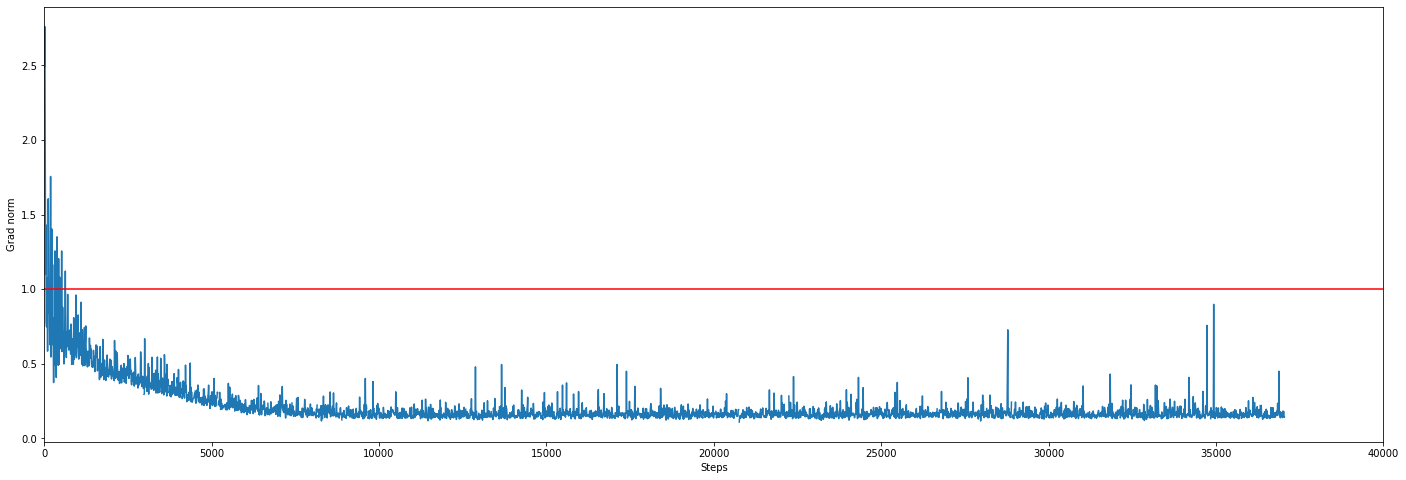

In [77]:
norm_ = [n.detach().cpu() for n in norm]
plt.figure(figsize=(24, 8))
plt.plot(list(range(1, len(norm_)+1, 10)), norm_[::10])
plt.axhline(y=1, xmin=0, color='r')
plt.xlabel('Steps')
plt.xlim(0, 40000)
plt.ylabel('Grad norm')
plt.savefig('gnorm.png')
plt.show()

# Plot positional embeddings

2022-03-29 13:20:46 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-big/checkpoint_last.pt: step=36528 loss=2.9706804752349854 bleu=36.42864046982063


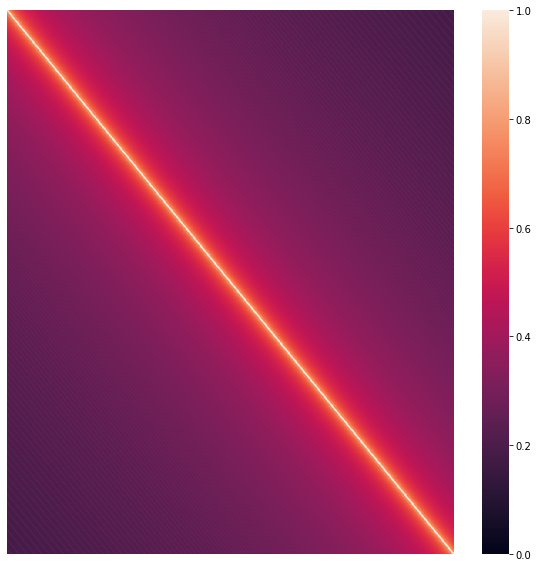

In [78]:
try_load_checkpoint(model, optimizer, name=config.resume)
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
N = pos_emb.shape[0]
cos_similarity = np.zeros((N, N))
for row in range(N):
    for col in range(N):
        cos_similarity[row, col] = F.cosine_similarity(pos_emb[row], pos_emb[col], dim=0).squeeze(-1)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(cos_similarity)
plt.xticks([])
plt.yticks([])
plt.savefig('positional_embedding.png')
plt.show()

# Submission

In [79]:
# averaging a few checkpoints can have a similar effect to ensemble
checkpoint_name = f"avg_last_{config.keep_last_epochs}_checkpoint.pt"
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints {config.keep_last_epochs} \
--output {checkdir}/{checkpoint_name}

No protocol specified
Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-big'], num_epoch_checkpoints=15, num_update_checkpoints=None, output='./checkpoints/transformer-big/avg_last_15_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-big/checkpoint50.pt', './checkpoints/transformer-big/checkpoint49.pt', './checkpoints/transformer-big/checkpoint48.pt', './checkpoints/transformer-big/checkpoint47.pt', './checkpoints/transformer-big/checkpoint46.pt', './checkpoints/transformer-big/checkpoint45.pt', './checkpoints/transformer-big/checkpoint44.pt', './checkpoints/transformer-big/checkpoint43.pt', './checkpoints/transformer-big/checkpoint42.pt', './checkpoints/transformer-big/checkpoint41.pt', './checkpoints/transformer-big/checkpoint40.pt', './checkpoints/transformer-big/checkpoint39.pt', './checkpoints/transformer-big/checkpoint38.pt', './checkpoints/transformer-big/checkpoint37.pt', './checkpoints/transformer-big/checkpoint36.pt']
Finished writing

## Confirm model weights used to generate submission

In [80]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name=checkpoint_name)
validate(model, task, criterion, log_to_wandb=False)
None

2022-03-29 13:21:10 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-big/avg_last_15_checkpoint.pt: step=unknown loss=2.9706804752349854 bleu=36.42864046982063
2022-03-29 13:21:10 | INFO | hw5.seq2seq | begin validation


2022-03-29 13:21:50 | INFO | hw5.seq2seq | example source: so this is already evidence of how , in the academic literature , we will see a biased sample of the true picture of all of the scientific studies that have been conducted .
2022-03-29 13:21:50 | INFO | hw5.seq2seq | example hypothesis: 這已經是學術文獻中如何產生偏頗結果的證據 , 在已進行的科學研究中 , 我們會有一個偏頗的樣本 。
2022-03-29 13:21:50 | INFO | hw5.seq2seq | example reference: 由此可見 , 在學術界裡許多科學研究都存在一種特定偏見
2022-03-29 13:21:50 | INFO | hw5.seq2seq | validation loss:	2.9424
2022-03-29 13:21:50 | INFO | hw5.seq2seq | BLEU = 36.84 63.9/42.6/30.5/23.1 (BP = 0.990 ratio = 0.990 hyp_len = 110707 ref_len = 111811)


## Generate Prediction

In [81]:
generate_prediction(model, task, outfile="prediction.txt")

2022-03-29 13:21:50 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.en
2022-03-29 13:21:50 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.zh
2022-03-29 13:21:50 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction: 100%|██████████| 26/26 [00:34<00:00,  1.33s/it]


In [82]:
!head prediction.txt -n 5

所以我們做的第一件事就是給成人一個我們給小孩子的版本海盜問題
這是唯一的解釋 。 因為為什麼你需要告訴人們某個東西是炎熱的 ?
謝謝 。
儘管源源源不絕地制定公制 , 許多美國人認為用腳和英鎊比較直觀 。
然後我們製作了一張概率地圖 , 標示他們可能去過哪裡 。
